<a href="https://colab.research.google.com/github/delodealexandre/qiskit/blob/master/20221025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ECE 802 - Optimisation

### Project

In [1]:
import sympy as sp
import sympy
import math
from sympy.abc import x, y
from sympy import *
from sympy import ordered, Matrix, hessian
import numpy as np
from sympy.series.sequences import RecursiveSeq

In [2]:
import sys
sys.path.append('C:/users/adelod01/anaconda3/envs/optim/lib/site-packages/')
import itertools
sub=['₀','₁','₂','₃','₄','₅','₆','₇','₈','₉']

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

---
**Alexandre Delode**<br />
2nd year PhD Student <br />
Special Scientist, EU Erigrid research program<br />
FOSS Research Centre for Sustainable Energy<br />
Department of Electrical and Computer Engineering<br />
University of Cyprus<br />
delode.alexandre@ucy.ac.cy

![download.png](attachment:4859108f-99db-4579-bf8b-fdde2c823469.png)

![A1.png](./Image/A1.png)

In [4]:
#Sympy implementation
alpha=Symbol('alpha')
x=Symbol('x')
y=Symbol('y')
v=100*(y-x**2)**2+(1-x)**2
v

(1 - x)**2 + 100*(-x**2 + y)**2

In [5]:
gradient = lambda f, v: Matrix([f]).jacobian(v)

In [6]:
gr=gradient(v,(x,y))
statpoint=solve(gr, (x,y))
print("stationary points")
display(statpoint)

stationary points


[(1, 1)]

In [7]:
display(Transpose(gr))

Matrix([[-400*x*(-x**2 + y) + 2*x - 2, -200*x**2 + 200*y]]).T

In [8]:
#Verify the points
hes=hessian(v,(x,y))
eigenvalues=[]
for i,ele in enumerate(statpoint):
    ele=(ele[0],ele[1])
    print("stationary points: #",i+1, " \n        position :", ele,\
          " \n        value :", v.subs(x,ele[0]).subs(y,ele[1]))
    for key in hes.eigenvals():
        eigenvalues+=[key.subs(x,ele[0]).subs(y,ele[1])]
    print("        eigenvalues : " , eigenvalues)
    if all([ele>0 for ele in eigenvalues]):
        print("        Minimum point")
    elif all([ele<0 for ele in eigenvalues]):
        print("        Maximum point")
    elif all([ele!=0 for ele in eigenvalues]):
        print("        Saddle point")
    else:
        print("        Indeterminate case / further derivations could be required")

stationary points: # 1  
        position : (1, 1)  
        value : 0
        eigenvalues :  [501 - sqrt(250601), sqrt(250601) + 501]
        Minimum point


![A2.png](./Image/A2.png)

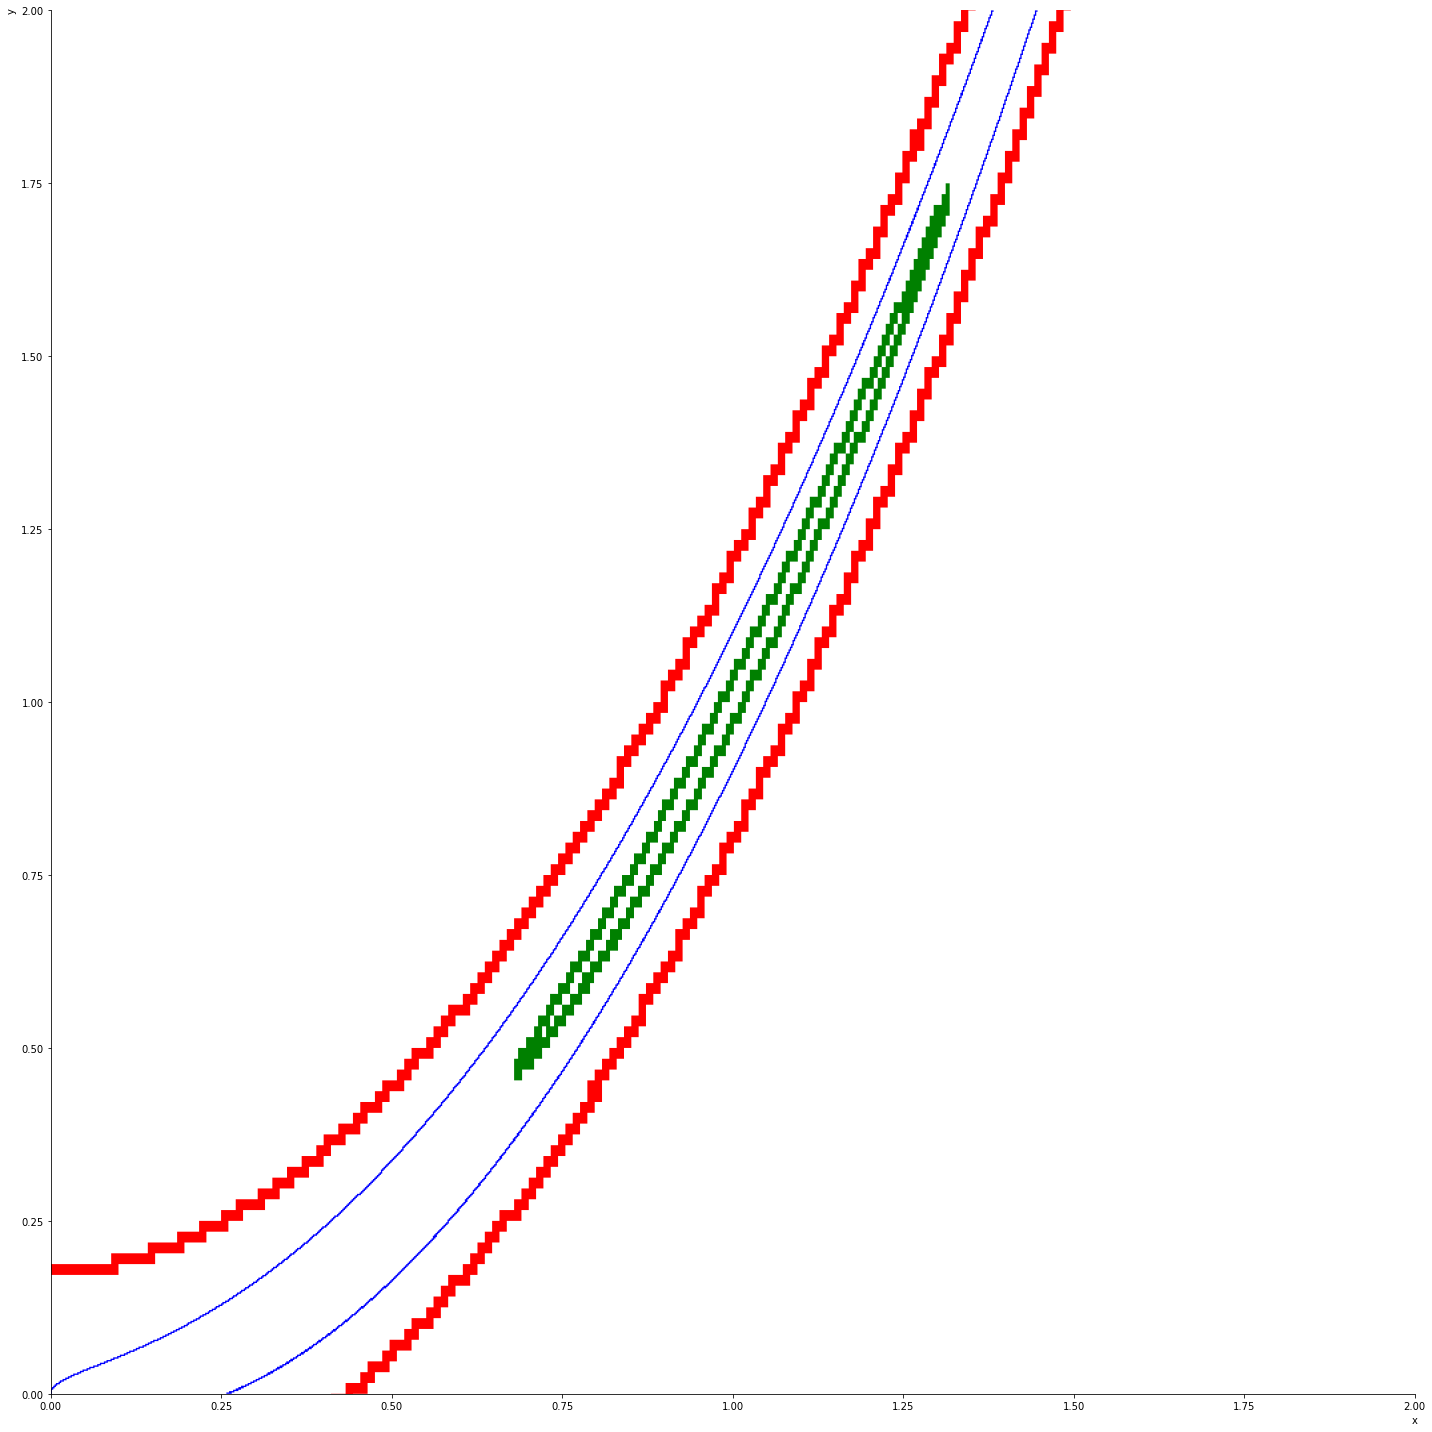

In [9]:
new_size = plt.rcParams["figure.figsize"] = (20,20)
p1 = plot_implicit(Eq(v, 0.1), (x, -3, 3), (y, -8, 8), show=False, line_color='g')
p2 = plot_implicit(Eq(v, 4), (x, -8, 3), (y, -8, 8), show=False, line_color='r')
p3 = plot_implicit(Eq(v, 1), (x, -0, 2), (y, -0, 2), show=False, line_color='b')
p3.extend(p1)
p3.extend(p2)
p3.show()

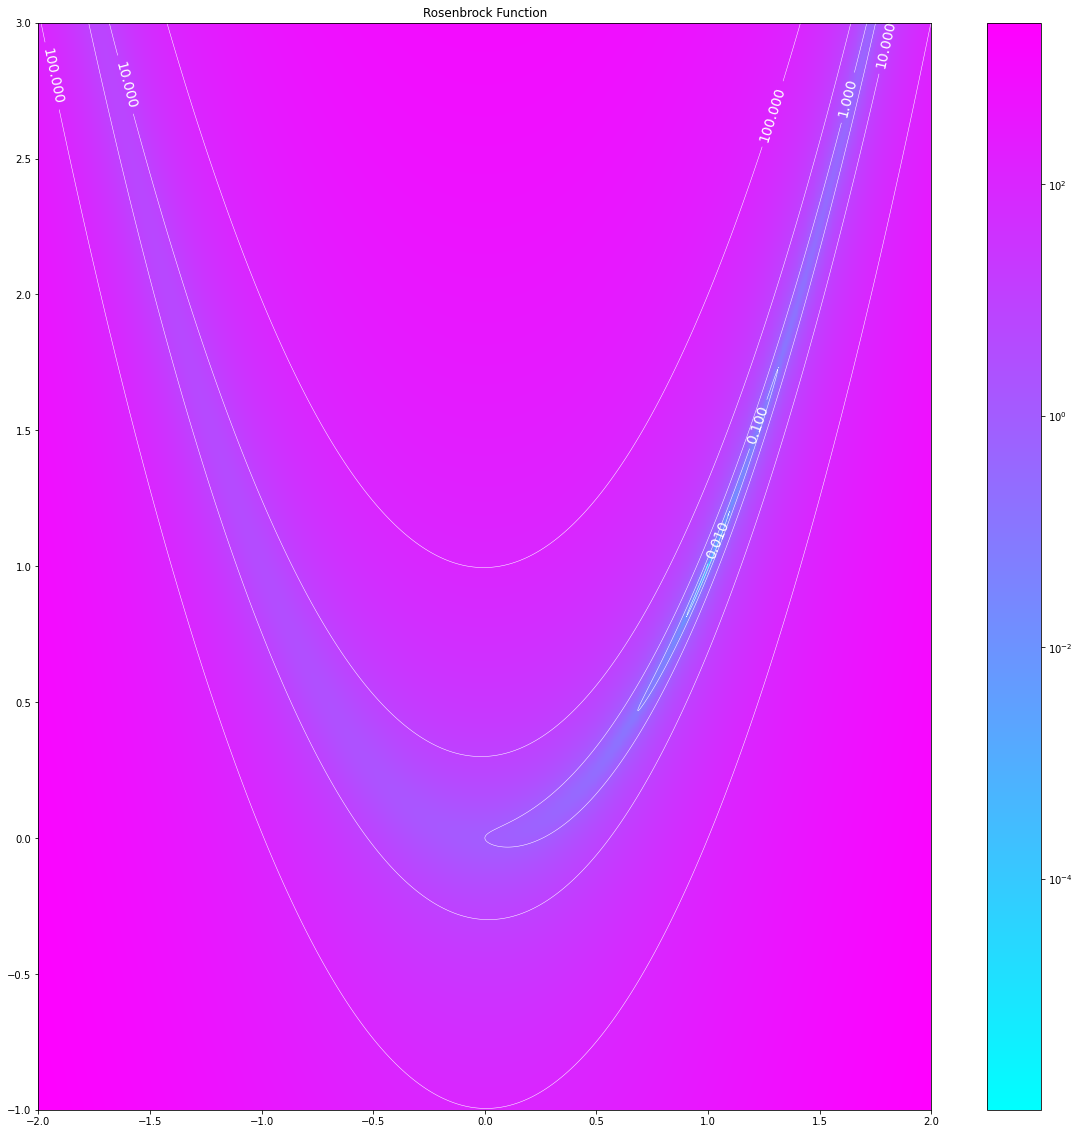

In [10]:


new_size = plt.rcParams["figure.figsize"] = (20,20)


X, Y = np.meshgrid(np.linspace(-2, 2, 1000), np.linspace(-1, 3, 1000))
vfunc = lambdify([x,y],v)

Z = vfunc(X,Y) 

fig, ax = plt.subplots()

pcm = ax.pcolor(X, Y, Z,
                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='cool')



fig.colorbar(pcm, ax=ax)
CS=ax.contour(X, Y, Z, levels=[10**(-2),10**(-1),10**(0),10**1,10**(2)],\
              linewidths=0.5, colors='w')
ax.clabel(CS, inline=True, fontsize=14)
ax.set(xlim=(-2, 2), ylim=(-1, 3))
ax.set_title('Rosenbrock Function')

plt.show()

![A3.png](./Image/A3.png)

# General Unconstrained Minimization :

![General Unconstrained Algorithm.png](./Image/General_Unconstrained_Algorithm.png)

# Gradient Method :

![GradientMethod.png](./Image/GradientMethod.png)

In [11]:
def gradientmethodrecurrence(v):
    gradient = lambda f, v: Matrix([f]).jacobian(v)
    gr=gradient(v,(x,y))
    #gradient
    k = Dummy("k")
    coeff=-Matrix(alpha*Transpose(gr)) #antigradient
    display(coeff)
    p1 = Function("p1")
    p2 = Function("p2")
    gradalgo1= RecursiveSeq(p1(k - 1) + coeff[0], p1(k), k)
    gradalgo2= RecursiveSeq(p2(k - 1) + coeff[1], p2(k), k)
    rhs1=gradalgo1.recurrence.subs(p1(k - 1),x).rhs
    rhs1=simplify(rhs1)
    rhs2=gradalgo2.recurrence.subs(p2(k - 1),y).rhs
    rhs2=simplify(rhs2)
    display(rhs1)
    display(rhs2)
    dk=-Transpose(gr) #antigradient
    return rhs1,rhs2,dk

In [12]:
rhs1,rhs2,dk=gradientmethodrecurrence(v)
print(dk)

Matrix([
[-alpha*(-400*x*(-x**2 + y) + 2*x - 2)],
[           -alpha*(-200*x**2 + 200*y)]])

-2*alpha*(200*x*(x**2 - y) + x - 1) + x

200*alpha*(x**2 - y) + y

Matrix([[400*x*(-x**2 + y) - 2*x + 2], [200*x**2 - 200*y]])


# Armijo Line Search :

![Armijo.png](./Image/Armijo.png)

In [13]:
def minimisationalgoArmijolinesearch(x0,y0,alpha0,sigma,gamma,dk,step,v):
    
    pointsx=[x0]
    pointsy=[y0]
    
    xk=x0
    yk=y0
    
    gradient = lambda f, v: Matrix([f]).jacobian(v)
    gr=gradient(v,(x,y))
    
    vfunc=lambdify([x,y],v)
    grfunc=lambdify([x,y],gr)
    dkfunc=lambdify([x,y],dk)
    
    for _ in range(step):

        alphaloop=alpha0

        while vfunc(xk+alphaloop*dkfunc(xk,yk)[0],yk+alphaloop*dkfunc(xk,yk)[1])\
              -vfunc(xk,yk)>\
               gamma*alphaloop*np.dot(grfunc(xk,yk),dkfunc(xk,yk)):
            alphaloop=sigma*alphaloop

        alphak=alphaloop
        
        xknext=xk+alphaloop*dkfunc(xk,yk)[0]
        yknext=yk+alphaloop*dkfunc(xk,yk)[1]
        xk=xknext[0]
        yk=yknext[0]

        pointsx+=[xk]
        pointsy+=[yk]
        
    print(xk,yk)
    

    
    return pointsx,pointsy

In [14]:
x0=-3/4
y0=1
alpha0=1 #usually 1
sigma=0.5 #0<sigma<1
gamma=0.25 #0<gamma<0.5
step=2500 #slow convergence


In [15]:
GradientX,GradientY=minimisationalgoArmijolinesearch(\
                    x0,y0,alpha0,sigma,gamma,dk,step,v)

0.9999999987621876 0.9999999975233659


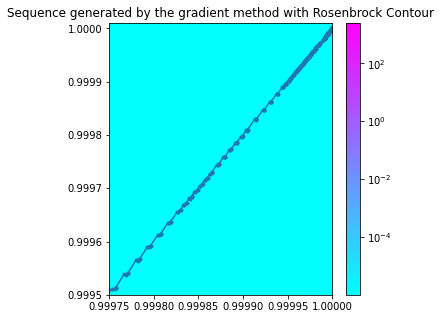

In [16]:
new_size = plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()



plt.title(\
"Sequence generated by the gradient method with Rosenbrock Contour")

ax.plot(GradientX,GradientY, marker='.')

X, Y = np.meshgrid(np.linspace(-2, 2, 1000), np.linspace(-1, 3, 1000))
vfunc = lambdify([x,y],v)

Z = vfunc(X,Y) 


pcm = ax.pcolor(X, Y, Z,
                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='cool')



fig.colorbar(pcm, ax=ax)
CS=ax.contour(X, Y, Z, levels=[10**(-2),10**(-1),10**(0),10**1,10**(2)],\
              linewidths=0.5, colors='w')
ax.clabel(CS, inline=True, fontsize=14)
ax.set(xlim=(0.99975, 1), ylim=(0.9995, 1.00001))


plt.show()

### Gradient descent: "slow staircase" effect

![A4.png](./Image/A4.png)

In [17]:
def minimisationalgofixedlinesearch(x0,y0,alpha0,rhs1,rhs2,step):
    
    pointsx=[x0]
    pointsy=[y0]
    
    rhs1func=lambdify([x,y,alpha],rhs1)
    rhs2func=lambdify([x,y,alpha],rhs2)
    
    xk=x0
    yk=y0
    alphak=alpha0
    for _ in range(step):
        tempx=xk
        tempy=yk
        xk=rhs1func(tempx,tempy,alphak)
        yk=rhs2func(tempx,tempy,alphak)
        
        pointsx+=[xk]
        pointsy+=[yk]
        
        
    print(xk,yk)
    
    return pointsx,pointsy

In [18]:
def Newtonmethodrecurrence(v):
    gradient = lambda f, v: Matrix([f]).jacobian(v)
    gr=gradient(v,(x,y))
    #gradient
    k = Dummy("k")
    hes=hessian(v,[x,y])
    hesinv=hes.inv()
    coeff=-alpha*hesinv*Transpose(gr)
    p1 = Function("p1")
    p2 = Function("p2")
    gradalgo1= RecursiveSeq(p1(k - 1) + coeff[0], p1(k), k)
    gradalgo2= RecursiveSeq(p2(k - 1) + coeff[1], p2(k), k)
    rhs1=gradalgo1.recurrence.subs(p1(k - 1),x).rhs
    rhs1=simplify(rhs1)
    rhs2=gradalgo2.recurrence.subs(p2(k - 1),y).rhs
    rhs2=simplify(rhs2)
    display(simplify(rhs1))
    display(simplify(rhs2))
    dk=-hesinv*Transpose(gr)
    return rhs1,rhs2,dk

In [19]:
rhs1,rhs2,dk=Newtonmethodrecurrence(v)

(-alpha*x + alpha + 200*x**3 - 200*x*y + x)/(200*x**2 - 200*y + 1)

(-2*alpha*x*(200*x*(x**2 - y) + x - 1) + alpha*(x**2 - y)*(600*x**2 - 200*y + 1) + y*(200*x**2 - 200*y + 1))/(200*x**2 - 200*y + 1)

In [20]:
dk

Matrix([
[                             -x*(-200*x**2 + 200*y)/(200*x**2 - 200*y + 1) - (-400*x*(-x**2 + y) + 2*x - 2)/(400*x**2 - 400*y + 2)],
[-x*(-400*x*(-x**2 + y) + 2*x - 2)/(200*x**2 - 200*y + 1) - (-200*x**2 + 200*y)*(600*x**2 - 200*y + 1)/(40000*x**2 - 40000*y + 200)]])

In [21]:
x0=-3/4
y0=1
alpha0=1
step=200

In [22]:
%%time
NewtonX,NewtonY=minimisationalgofixedlinesearch(x0,y0,alpha0,rhs1,rhs2,step) 

0.9999999999999798 1.0
CPU times: user 9.01 ms, sys: 77 µs, total: 9.09 ms
Wall time: 8.88 ms


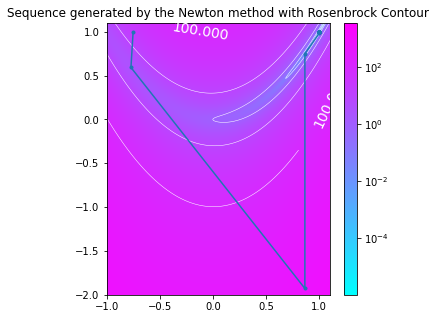

In [23]:
new_size = plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()
plt.title(\
"Sequence generated by the Newton method with Rosenbrock Contour")
ax.plot(NewtonX,NewtonY, marker='.')
X, Y = np.meshgrid(np.linspace(-2, 2, 1000), np.linspace(-2, 3, 1000))
vfunc = lambdify([x,y],v)
Z = vfunc(X,Y) 
pcm = ax.pcolor(X, Y, Z,
                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='cool')
fig.colorbar(pcm, ax=ax)
CS=ax.contour(X, Y, Z, levels=[10**(-2),10**(-1),10**(0),10**1,10**(2)],\
              linewidths=0.5, colors='w')
ax.clabel(CS, inline=True, fontsize=14)
ax.set(xlim=(-1, 1.1), ylim=(-2, 1.1))
plt.show()

### Newton method: "it converges fast or it does not converge"

In [24]:
x0=-3/4
y0=1
alpha0=1 #usually 1
sigma=0.5 #0<sigma<1
gamma=0.25 #0<gamma<0.5
step=200 

In [25]:
%%time
ModNewtonX,ModNewtonY=minimisationalgoArmijolinesearch(\
                    x0,y0,alpha0,sigma,gamma,dk,step,v)

1.0000000000000027 1.0000000000000056
CPU times: user 16.7 s, sys: 1.57 s, total: 18.3 s
Wall time: 15.9 s


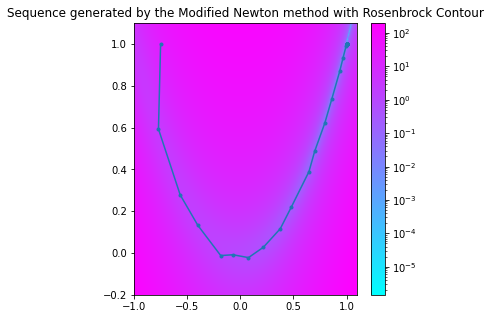

In [26]:
new_size = plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()
plt.title("\
Sequence generated by the Modified Newton method with Rosenbrock Contour")
ax.plot(ModNewtonX,ModNewtonY, marker='.')
X, Y = np.meshgrid(np.linspace(-1, 1.1, 1000), np.linspace(-0.2, 1.1, 1000))
vfunc = lambdify([x,y],v)
Z = vfunc(X,Y) 
pcm = ax.pcolor(X, Y, Z,
                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='cool')
fig.colorbar(pcm, ax=ax)
ax.set(xlim=(-1, 1.1), ylim=(-0.2, 1.1))

plt.show()

### Modified Newton method: "it does not improve Newton Method"

![A5.png](./Image/A5.png)

# Polak-Ribiere algorithm :

![Polak.png](./Image/Polak.png)

![Polak2.png](./Image/Polak2.png)

In [27]:
def PolakRibiere(x0,y0,alpha0,sigma,gamma,step,v):
    
    pointsx=[x0]
    pointsy=[y0]
    
    xk=x0
    yk=y0
    
    k=0
    
    vfunc=lambdify([x,y],v)

    gradient = lambda f, v: Matrix([f]).jacobian(v)
    gr=gradient(v,(x,y))
    #gradient
    grfunc=lambdify([x,y],gr)
    
    for _ in range(step):


        #display(grfunc(xk,yk)[0,1])
        if grfunc(xk,yk)[0,0]==0 and grfunc(xk,yk)[0,1]==0:
            break
        else:
            if k==0:
                dk=-grfunc(xk,yk)
                k=k+1
            else:
                dk=-grfunc(xk,yk)+\
                np.inner(grfunc(xk,yk),grfunc(xk,yk)-grfunc(xkp,ykp))/\
                np.inner(grfunc(xkp,ykp),grfunc(xkp,ykp))*dkp
        
        #print(dk)
        #Armijo Line search
        alphaloop=alpha0

        while vfunc(xk+alphaloop*dk[0,0],yk+alphaloop*dk[0,1])\
                -vfunc(xk,yk)>\
                gamma*alphaloop*np.inner(grfunc(xk,yk),dk):
            
            alphaloop=sigma*alphaloop
            
        alphak=alphaloop
        
        #display(dk[0,0])
        #display(dk[0,1])
        xknext=xk+alphak*dk[0,0]
        yknext=yk+alphak*dk[0,1]
        
        dkp=dk
        xkp=xk
        ykp=yk
        
        xk=xknext
        yk=yknext
    
        pointsx+=[xk]
        pointsy+=[yk]
    print(xk,yk)
    #print(np.shape(dk))
    
    return pointsx,pointsy

In [28]:
x0=-3/4
y0=1
alpha0=1 #usually 1
sigma=0.5 #0<sigma<1
gamma=0.25 #0<gamma<0.5
step=200 

In [29]:
%%time
PRX,PRY=PolakRibiere(x0,y0,alpha0,sigma,gamma,step,v)

0.9999999999999973 0.9999999999999947
CPU times: user 1.33 s, sys: 93.1 ms, total: 1.43 s
Wall time: 1.33 s


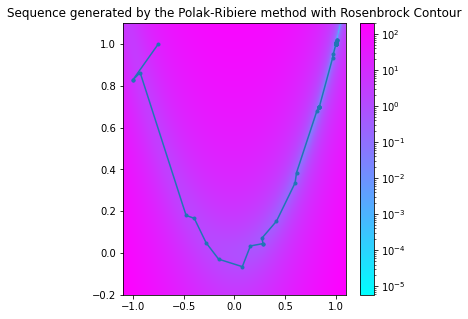

In [30]:
new_size = plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()
plt.title("Sequence generated by the Polak-Ribiere method with Rosenbrock Contour")
ax.plot(PRX,PRY, marker='.')
X, Y = np.meshgrid(np.linspace(-1.1, 1.1, 1000), np.linspace(-0.2, 1.1, 1000))
vfunc = lambdify([x,y],v)
Z = vfunc(X,Y) 
pcm = ax.pcolor(X, Y, Z,
                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='cool')
fig.colorbar(pcm, ax=ax)
ax.set(xlim=(-1.1, 1.1), ylim=(-0.2, 1.1))
plt.show()

## Polak Ribiere method : No second derivative and no inversion, faster computation

![A6.png](./Image/A6.png)

# Quasi newton method :

![QuasiNewton.png](./Image/QuasiNewton.png)

![QuasiNewtoneq.png](./Image/QuasiNewtoneq.png)

![QuasiNewtonGammaDelta.png](./Image/QuasiNewtonGammaDelta.png)

![BroydenUpdate.png](./Image/BroydenUpdate.png)

With $\phi=1$ (BFGS)

![vk.png](./Image/vk.png)

![BFGSalgo.png](./Image/BFGSalgo.png)

In [31]:
def BFGSeq(Hk,xk,yk,xkn,ykn,v):
    
    gradient = lambda f, v: Matrix([f]).jacobian(v)
    gr=gradient(v,(x,y))

    grfunc=lambdify([x,y],gr)
    
    deltak=np.array([[xkn-xk],[ykn-yk]])

    gammak=grfunc(xkn,ykn)-grfunc(xk,yk)
    gammak=np.transpose(gammak)

    tbsqrt=np.transpose(gammak)@Hk@gammak

    vk= np.sqrt(tbsqrt)[0,0] * ( deltak /(np.transpose(deltak)@gammak+10**-20) -\
                                Hk@gammak/(np.transpose(gammak)@Hk@gammak+10**-20) )
    return Hk+(deltak@np.transpose(deltak))/(np.transpose(deltak)@gammak+10**-20)-\
        Hk@gammak@np.transpose(gammak)@Hk/(np.transpose(gammak)@Hk@gammak+10**-20) \
            +vk@np.transpose(vk)
    # additional term 10**-20 to avoid divided by zero computation error

It works also with :   vk=0;   temp=deltak; deltak=gammak; gammak=temp; return np.linalg.inv(...) \
Bonnans, J. Frédéric; Gilbert, J. Charles; Lemaréchal, Claude; Sagastizábal, Claudia A. (2006), "Newtonian Methods", Numerical Optimization: Theoretical and Practical Aspects (Second ed.), Berlin: Springer, pp. 55, ISBN 3-540-35445-X

In [32]:
def BFGSalgo(x0,y0,alpha0,sigma,gamma,step,v):
    
    pointsx=[x0]
    pointsy=[y0]
    
    xk=x0
    yk=y0
    
    k=0
    
    vfunc=lambdify([x,y],v)
    
    gradient = lambda f, v: Matrix([f]).jacobian(v)
    gr=gradient(v,(x,y))
    #gradient
    grfunc=lambdify([x,y],gr)
    
    for _ in range(step):

        if grfunc(xk,yk)[0,0]==0 and grfunc(xk,yk)[0,1]==0:
            break
            
        if k==0:
            Hk=np.eye(2)
            k=k+1
        else:
            Hk=BFGSeq(Hkp,xkp,ykp,xk,yk,v)
                
        dk=-Hk@np.transpose(grfunc(xk,yk))
        dk=np.transpose(dk)
        
        
        #Armijo line search
        alphaloop=alpha0

        while vfunc(xk+alphaloop*dk[0,0],yk+alphaloop*dk[0,1])-\
              vfunc(xk,yk)>\
              gamma*alphaloop*np.inner(grfunc(xk,yk),dk):
            alphaloop=sigma*alphaloop
        alphak=alphaloop

        xknext=xk+alphak*dk[0,0]
        yknext=yk+alphak*dk[0,1]

        xkp=xk
        ykp=yk
        Hkp=Hk

        xk=xknext
        yk=yknext

        pointsx+=[xk]
        pointsy+=[yk]
    print(xk,yk)
    return pointsx,pointsy

In [33]:
x0=-3/4
y0=1
alpha0=1 #usually 1
sigma=0.5 #0<sigma<1
gamma=0.25 #0<gamma<0.5
step=200 

In [34]:
%%time
BFGSX,BFGSY=BFGSalgo(x0,y0,alpha0,sigma,gamma,step,v) 

1.0 1.0
CPU times: user 121 ms, sys: 1.5 ms, total: 123 ms
Wall time: 122 ms


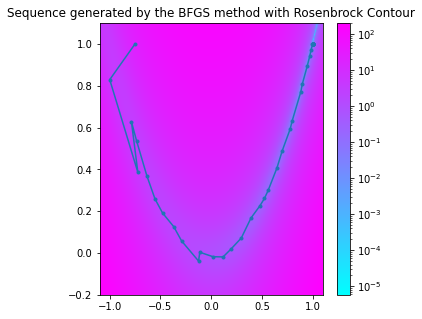

In [35]:
new_size = plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()
plt.title("Sequence generated by the BFGS method with Rosenbrock Contour")
ax.plot(BFGSX,BFGSY, marker='.')
X, Y = np.meshgrid(np.linspace(-1.1, 1.1, 1000), np.linspace(-0.2, 1.1, 1000))
vfunc = lambdify([x,y],v)
Z = vfunc(X,Y) 
pcm = ax.pcolor(X, Y, Z,
                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='cool')
fig.colorbar(pcm, ax=ax)
ax.set(xlim=(-1.1, 1.1), ylim=(-0.2, 1.1))
plt.show()

## BFGS method : Even faster computation than Polak Ribiere

![A7.png](./Image/A7.png)

### Improved simplex method from:
Nocedal, J, and S J Wright. 2006. Numerical Optimization. pg 238. Springer New York.
### and generalised from:
https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method (visited on 25/10/2022)
### with equivalence between the two references as:

Reflection point : $t=-1 \leftrightarrow \alpha=1$ 

Expansion point : $t=-2 \leftrightarrow \gamma=2$

Outside contraction point : $t=-\frac{1}{2} \leftrightarrow \rho\alpha=\frac{1}{2}$

Inside contraction point : $t=\frac{1}{2} \leftrightarrow \rho=\frac{1}{2}$ 

Shrunk simplex : $\sigma=\frac{1}{2}$

In [36]:

def Simplex(x0,y0,s,step,v,a=1,gamma=2,rho=0.5,sigma=0.5):
    
    pointsx=[x0]
    pointsy=[y0]
    
    vfunc=lambdify([x,y],v)
    
    #let's define the two other vertices
    x1=x0+s
    y1=y0
    
    x2=x0
    y2=y0+s
    
    vlist=[[x0,y0],[x1,y1],[x2,y2]]
    vlistgraph=[[[x0,y0],[x1,y1],[x2,y2]]]
    for _ in range(step):
        #ordered list according to function values
        vlist=sorted(vlist, key=lambda ele:vfunc(ele[0],ele[1]))
        
        xmax=vlist[2][0]
        ymax=vlist[2][1]
        
        #centroid of the vertices except max
        xc=0
        yc=0
        for i in range(2):
            xc=xc+vlist[i][0]/2
            yc=yc+vlist[i][1]/2
 
        #reflection point
        xr=xc+a*(xc-xmax)
        yr=yc+a*(yc-ymax)
        
        #position of the reflection point:
        #better than the second worst but worse than the best?
        if vfunc(vlist[0][0],vlist[0][1])<=vfunc(xr,yr) and\
           vfunc(xr,yr)<vfunc(vlist[1][0],vlist[1][1]):
            vlist[2][0]=xr
            vlist[2][1]=yr
        
        #position of the reflection point:
        #better than the best?
        elif vfunc(xr,yr)<vfunc(vlist[0][0],vlist[0][1]):
            #expansion point
            xe=xc+gamma*(xr-xc)
            ye=yc+gamma*(yr-yc)
            #let's try to expand the simplex
            if vfunc(xe,ye)<vfunc(xr,yr):
                vlist[2][0]=xe
                vlist[2][1]=ye
            else:
                vlist[2][0]=xr
                vlist[2][1]=yr
        
        #position of the reflection point:
        #it is certain at this stage that worse than the second worst.
        #better than the worst?
        elif vfunc(xr,yr) < vfunc(vlist[2][0],vlist[2][1]) :
                #Outside contraction point
                xco=xc+rho*(xr-xc)
                yco=yc+rho*(yr-yc)
                
                if vfunc(xco,yco)<vfunc(xr,yr) :
                    vlist[2][0]=xco
                    vlist[2][1]=yco
                else:
                    #Shrunk simplex
                    vlist[1][0]=vlist[0][0]+sigma*(vlist[1][0]-vlist[0][0])
                    vlist[1][1]=vlist[0][1]+sigma*(vlist[1][1]-vlist[0][1])
                    vlist[2][0]=vlist[0][0]+sigma*(vlist[2][0]-vlist[0][0])
                    vlist[2][1]=vlist[0][1]+sigma*(vlist[2][1]-vlist[0][1])
        
        #position of the reflection point:
        #it is certain at this stage that worse than the worst.
        else:
                #Inside contraction point
                xci=xc+rho*(vlist[2][0]-xc)
                yci=yc+rho*(vlist[2][1]-yc)
                if vfunc(xci,yci)<vfunc(vlist[2][0],vlist[2][1]) :
                    vlist[2][0]=xci
                    vlist[2][1]=yci
                else:
                    #Shrunk simplex
                    vlist[1][0]=vlist[0][0]+sigma*(vlist[1][0]-vlist[0][0])
                    vlist[1][1]=vlist[0][1]+sigma*(vlist[1][1]-vlist[0][1])
                    vlist[2][0]=vlist[0][0]+sigma*(vlist[2][0]-vlist[0][0])
                    vlist[2][1]=vlist[0][1]+sigma*(vlist[2][1]-vlist[0][1])
            

        #print(xc,yc)
        pointsx+=[xc]
        pointsy+=[yc]
        vlistgraph+=[[[vlist[0][0],vlist[0][1]],[vlist[1][0],vlist[1][1]],[vlist[2][0],vlist[2][1]]]]
        #print(vlist)
    #print(vlistgraph)
        
    print(xc,yc)
    return pointsx,pointsy,vlistgraph

In [37]:
x0=-3/4
y0=1
s=0.5
step=200

In [38]:
%%time
SimplexX,SimplexY,vlistgraph=Simplex(x0,y0,s,step,v)

1.0 1.0
CPU times: user 5.22 ms, sys: 0 ns, total: 5.22 ms
Wall time: 4.91 ms


In [39]:
vlistgraph[1]

[[-0.75, 1], [-0.25, 1], [0.0, 0.0]]

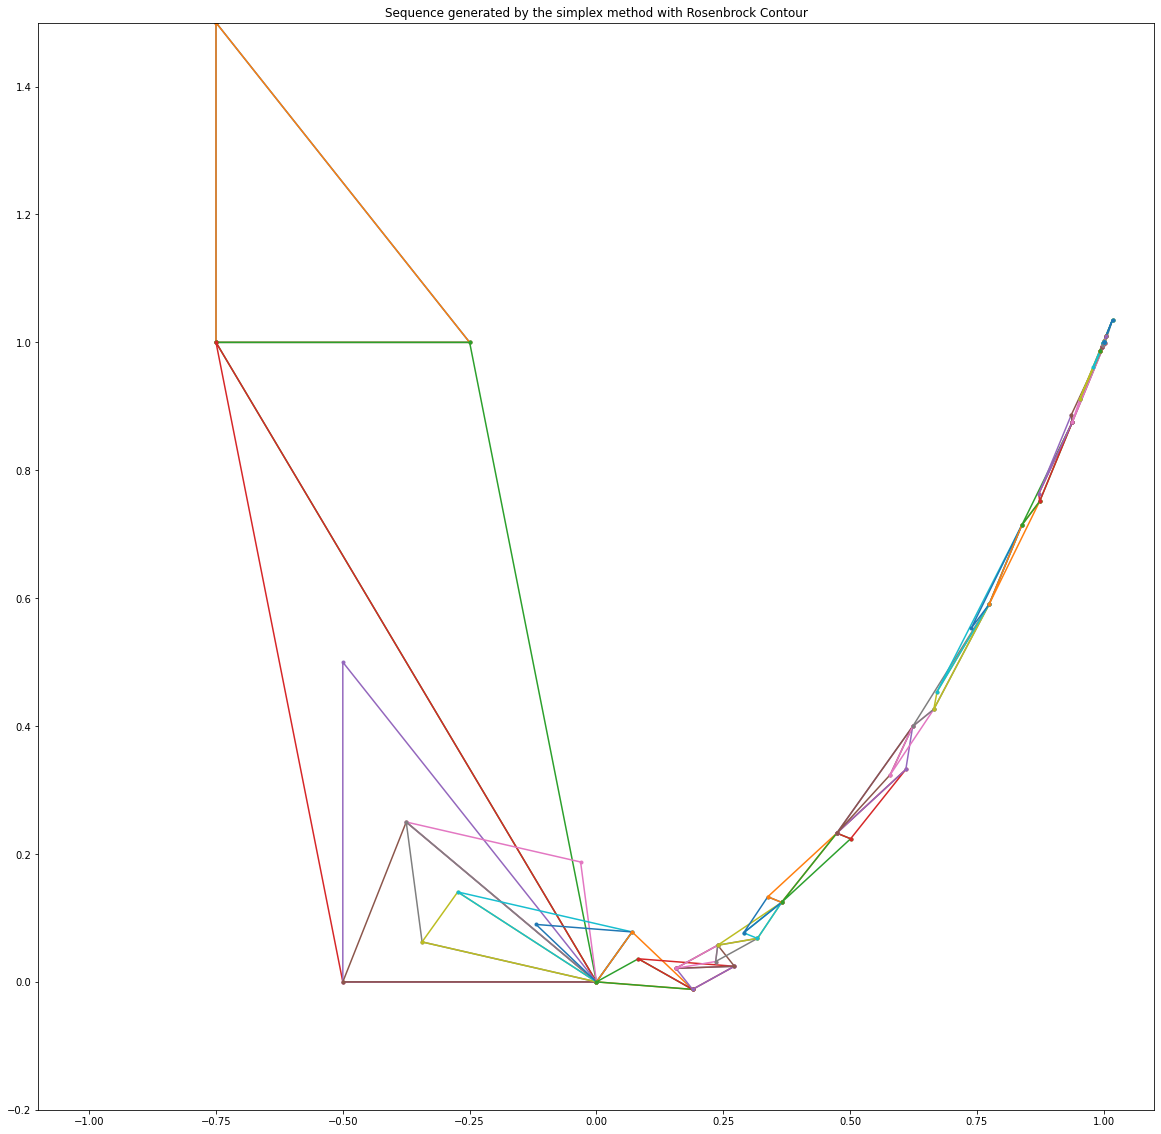

In [40]:
new_size = plt.rcParams["figure.figsize"] = (20,20)
fig, ax = plt.subplots()
plt.title("Sequence generated by the simplex method with Rosenbrock Contour")
ax.plot([x0,x0+s,x0,x0],[y0,y0,y0+s,y0], marker='.')
for t in range(200):
    ax.plot([vlistgraph[t][0][0],vlistgraph[t][1][0],vlistgraph[t][2][0],vlistgraph[t][0][0]],[vlistgraph[t][0][1],vlistgraph[t][1][1],vlistgraph[t][2][1],vlistgraph[t][0][1]], marker='.')
X, Y = np.meshgrid(np.linspace(-1.1, 1.1, 1000), np.linspace(-0.2, 1.5, 1000))
vfunc = lambdify([x,y],v)
Z = vfunc(X,Y) 
ax.set(xlim=(-1.1, 1.1), ylim=(-0.2, 1.5))
plt.show()

## Simplex method : The simplex progressively shrinks
## and gets closer to the minimum

![A8a.png](./Image/A8a.png)

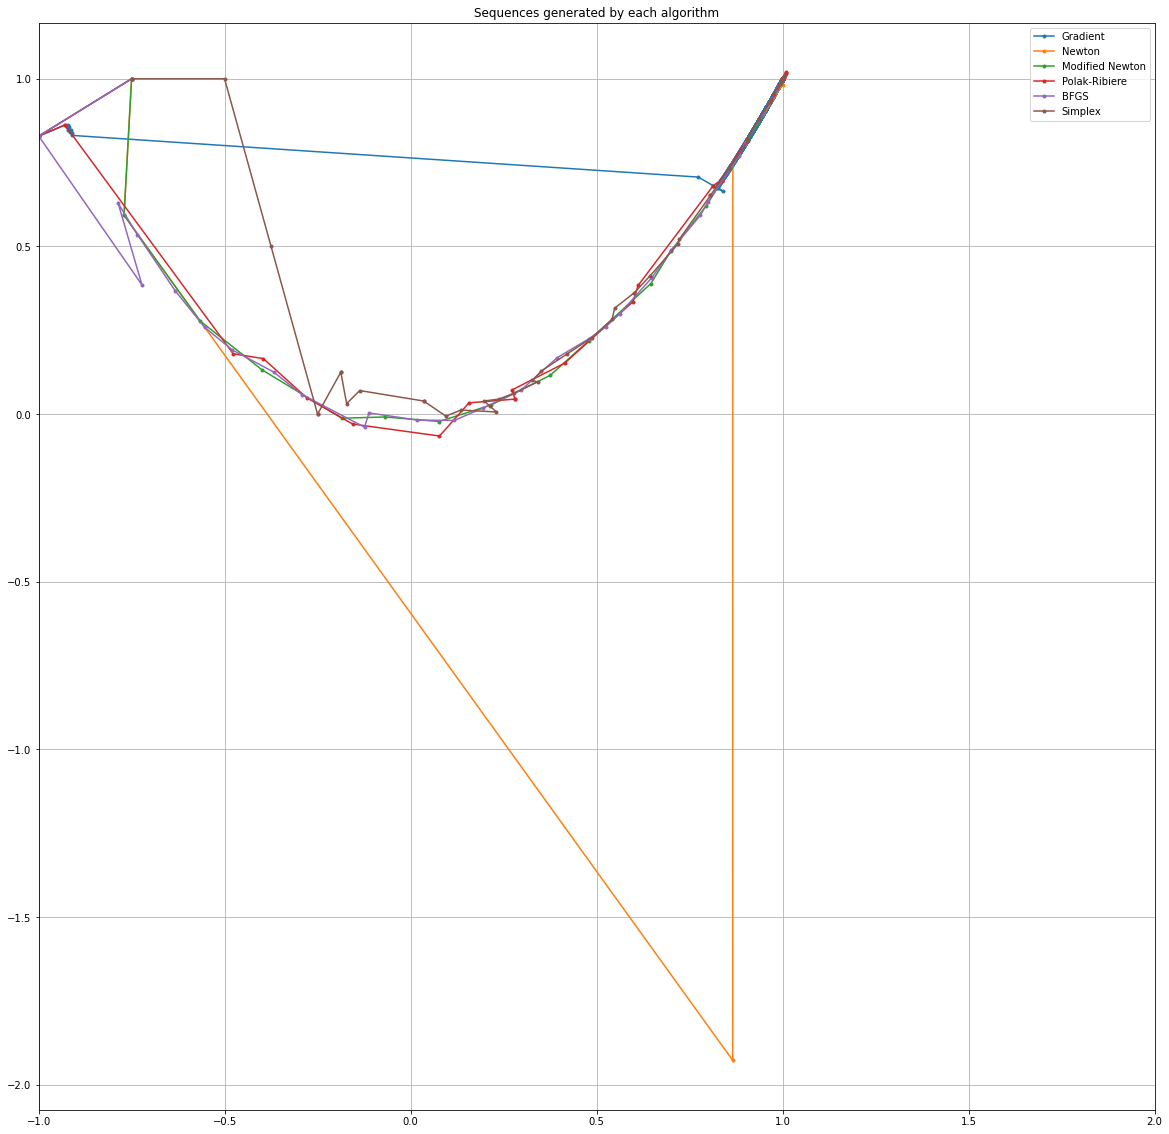

In [41]:
new_size = plt.rcParams["figure.figsize"] = (20,20)
fig, ax = plt.subplots()
plt.title("Sequences generated by each algorithm")
ax.plot(GradientX,GradientY, marker='.', label="Gradient")
ax.plot(NewtonX,NewtonY, marker='.', label="Newton")
ax.plot(ModNewtonX,ModNewtonY, marker='.', label="Modified Newton")
ax.plot(PRX, PRY, marker='.', label="Polak-Ribiere")
ax.plot(BFGSX, BFGSY, marker='.', label="BFGS")
ax.plot(SimplexX, SimplexY, marker='.', label="Simplex")
ax.set_xlim(-1, 2)
ax.grid(True)
ax.legend()
plt.show()

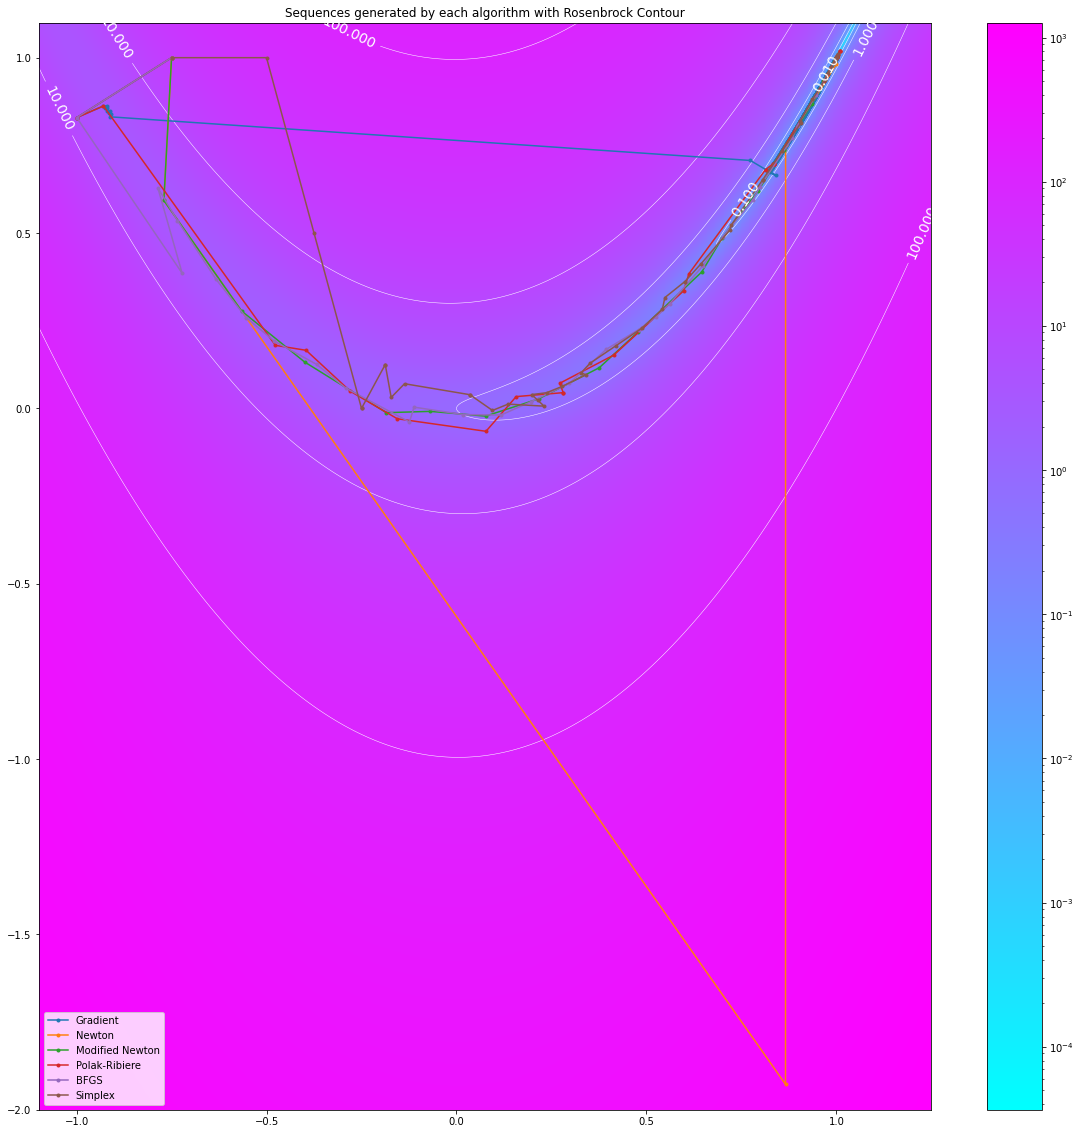

In [42]:
new_size = plt.rcParams["figure.figsize"] = (20,20)
fig, ax = plt.subplots()
plt.title("Sequences generated by each algorithm with Rosenbrock Contour")
ax.plot(GradientX,GradientY, marker='.', label="Gradient")
ax.plot(NewtonX,NewtonY, marker='.', label="Newton")
ax.plot(ModNewtonX,ModNewtonY, marker='.', label="Modified Newton")
ax.plot(PRX, PRY, marker='.', label="Polak-Ribiere")
ax.plot(BFGSX, BFGSY, marker='.', label="BFGS")
ax.plot(SimplexX, SimplexY, marker='.', label="Simplex")
X, Y = np.meshgrid(np.linspace(-1.1, 1.25, 1000), np.linspace(-2, 1.1, 1000))
vfunc = lambdify([x,y],v)
Z = vfunc(X,Y) 
pcm = ax.pcolor(X, Y, Z,
                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='cool')
fig.colorbar(pcm, ax=ax)
CS=ax.contour(X, Y, Z, levels=[10**(-2),10**(-1),10**(0),10**1,10**(2)],\
              linewidths=0.5, colors='w')
ax.clabel(CS, inline=True, fontsize=14)
ax.set(xlim=(-1.1, 1.25), ylim=(-2, 1.1))
ax.legend()
plt.show()

# All the sequences converge towards the point (1,1).

![A8b.png](./Image/A8b.png)

In [43]:
def cost(X,Y):
    costl=[]
    for k in range(len(X)):
        costl+=[math.log((X[k]-1)**2+(Y[k]-1)**2+10**-20)]
    return costl
# a negligible value has been added to avoid error in log computation

In [44]:
convlimit=math.log(10**-4**2)
convlimit

-36.841361487904734

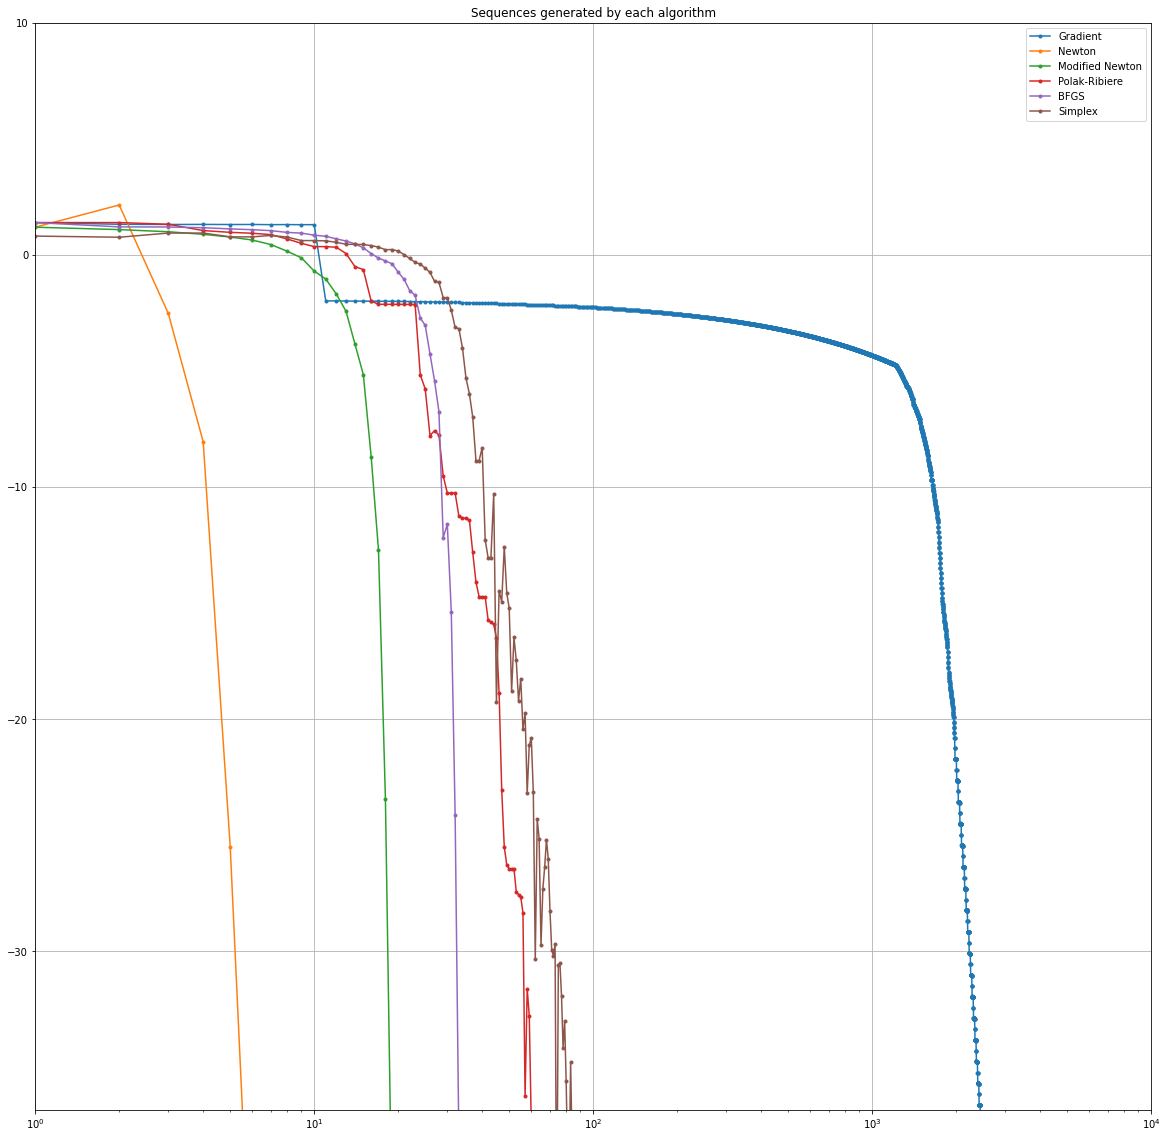

In [45]:
fig, ax = plt.subplots()
plt.title("Sequences generated by each algorithm")
ax.semilogx(cost(GradientX,GradientY), marker='.', label="Gradient")
ax.semilogx(cost(NewtonX,NewtonY), marker='.', label="Newton")
ax.semilogx(cost(ModNewtonX,ModNewtonY), marker='.', label="Modified Newton")
ax.semilogx(cost(PRX, PRY), marker='.', label="Polak-Ribiere")
ax.semilogx(cost(BFGSX, BFGSY), marker='.', label="BFGS")
ax.semilogx(cost(SimplexX, SimplexY), marker='.', label="Simplex")
ax.set_xlim(1, 10000)
ax.set_ylim(convlimit, 10)
ax.grid(True)
ax.legend()
plt.show()

With a convergence at $10^{-4}$, the different algorithms with ascending speed are:
- Gradient 
- Simplex
- Polak-Ribiere
- BFGS
- Modified Newton
- Newton

The number of iterations are \
(can also be read at the bottom of the log graph at the intersectin with $-36.8$): 

In [46]:
def minconv(cost, convlimit):
    min_value = convlimit  
    for i,x in enumerate(cost): 
        if x < min_value :
            return print("iteration number:", i)
print("##################")
print("Gradient")
minconv(cost(GradientX,GradientY),convlimit)
print("##################")
print("Simplex")
minconv(cost(SimplexX,SimplexY),convlimit)
print("##################")
print("Polak-Ribiere")
minconv(cost(PRX,PRY),convlimit)
print("##################")
print("BFGS")
minconv(cost(BFGSX,BFGSY),convlimit)
print("##################")
print("Modified Newton")
minconv(cost(ModNewtonX,ModNewtonY),convlimit)
print("##################")
print("Newton")
minconv(cost(NewtonX,NewtonY),convlimit)
print("##################")

##################
Gradient
iteration number: 2438
##################
Simplex
iteration number: 74
##################
Polak-Ribiere
iteration number: 60
##################
BFGS
iteration number: 33
##################
Modified Newton
iteration number: 19
##################
Newton
iteration number: 6
##################
